# VirusTotal project
**Combined Notebook**: data loading, cleaning, feature engineering + persistence in MongoDB, indexing, queries, and analysis.

Authors: Carmine Iemmino, Christian Gambardella

## 1. Setup & Imports


In [ ]:
!pip install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"



In [589]:
import os
from pathlib import Path
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient, ASCENDING, DESCENDING, TEXT
import time
from scipy.stats import zscore



## 2. Load JSONs into DataFrame
Load raw VirusTotal JSON files and preserve nested `scans` subdocument


In [590]:
def load_records(folder):
    for path in Path(folder).glob('*.json'):
        with open(path, encoding='utf-8') as f:
            yield json.load(f)

records = list(load_records('../data/VTAndroid'))
flat = pd.json_normalize(records, sep='_', max_level=2)
flat['scans'] = [r.get('scans', {}) for r in records]
print(f"Loaded {len(flat)} records with {flat.shape[1]} columns")

df = flat.copy()


Loaded 157 records with 353 columns


## 3. Initial Exploration


In [591]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Columns: 353 entries, vhash to scans
dtypes: bool(32), float64(14), int64(9), object(298)
memory usage: 398.8+ KB


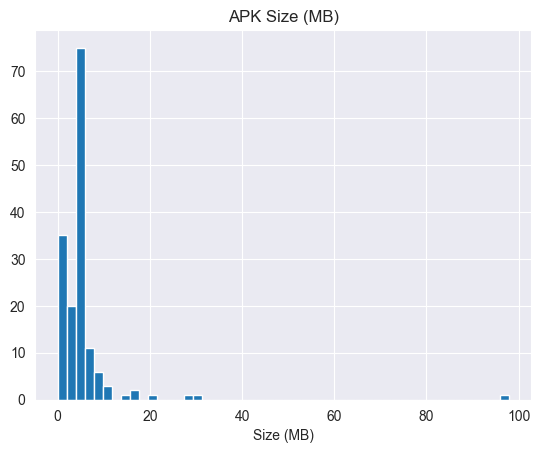

In [592]:
plt.hist(df['size'].dropna()/1e6, bins=50)
plt.title('APK Size (MB)')
plt.xlabel('Size (MB)')
plt.show()


This histogram is very right-skewed: the vast majority of APKs fall under around 10 MB (with a clear peak in the 2–5 MB range), and then there’s a long tail of a few much larger files stretching out toward 100 MB. That long, thin tail highlights a handful of unusually big packages, but most apps here are relatively compact.

## 4. Handling Missing Data


In [593]:
# Missing percentages
missing_pct = df.isna().mean().sort_values(ascending=False)
display(pd.DataFrame({'missing_pct': missing_pct}))


,missing_pct
scans_CMC_result,1.0
scans_VBA32_result,1.0
scans_Panda_result,1.0
scans_Malwarebytes_result,1.0
scans_SUPERAntiSpyware_result,1.0
...,...
scans_ESET-NOD32_update,0.0
scans_BitDefender_detected,0.0
scans_BitDefender_version,0.0
scans_BitDefender_update,0.0


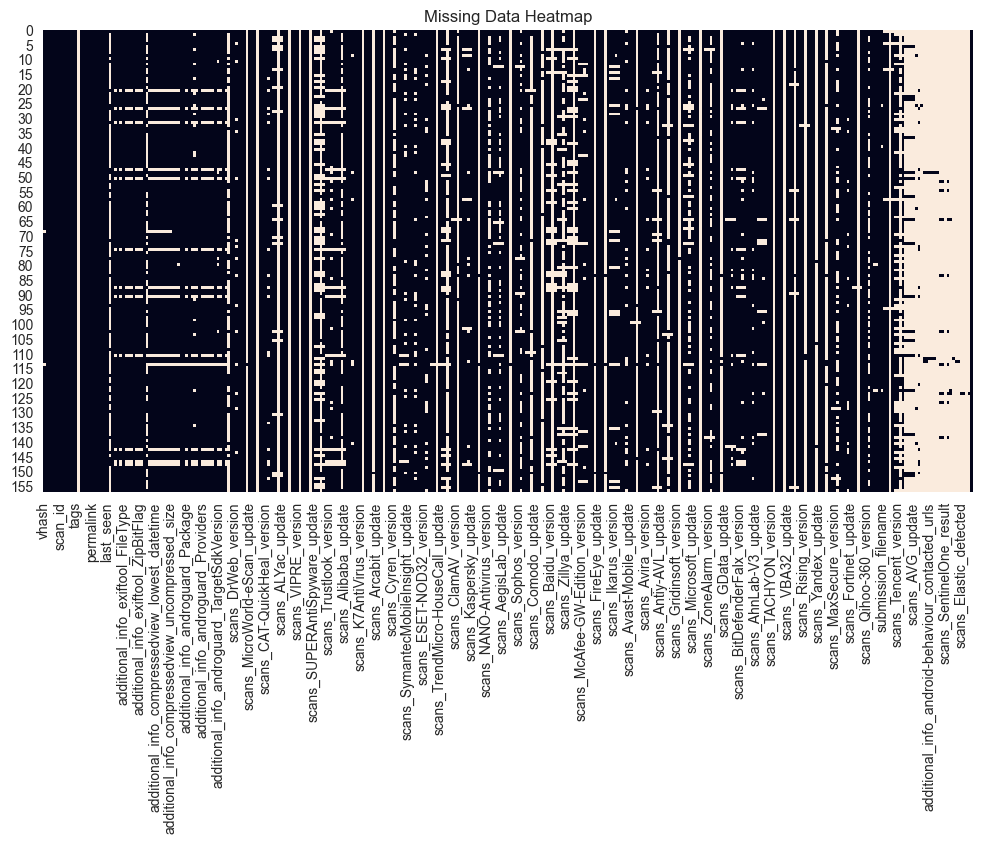

In [594]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title('Missing Data Heatmap')
plt.show()

The heatmap makes it clear that only a handful of essential attributes (the left-most columns) have near-complete coverage. Once you reach the long stretch of per-engine “scans_*” fields, there are vast gaps—many antivirus engines simply didn’t scan most samples—and the block of ancillary metadata on the right is almost entirely empty. This uneven distribution confirms our choice to discard any feature with over 80% null values and to restrict imputation to the well-populated numeric and categorical columns.

In [595]:
# Drop cols >80% missing
thresh = len(df) * 0.2
df = df.dropna(axis=1, thresh=thresh)


In [596]:
# Impute
num_cols = df.select_dtypes(include=['float64','int64']).columns
for c in num_cols:
    df[f'{c}_missing'] = df[c].isna()
    df[c] = df[c].fillna(df[c].median())


In [ ]:
obj_cols = df.select_dtypes(include=['object']).columns
for c in obj_cols:
    df[f'{c}_missing'] = df[c].isna()
    df[c] = df[c].fillna('UNKNOWN')


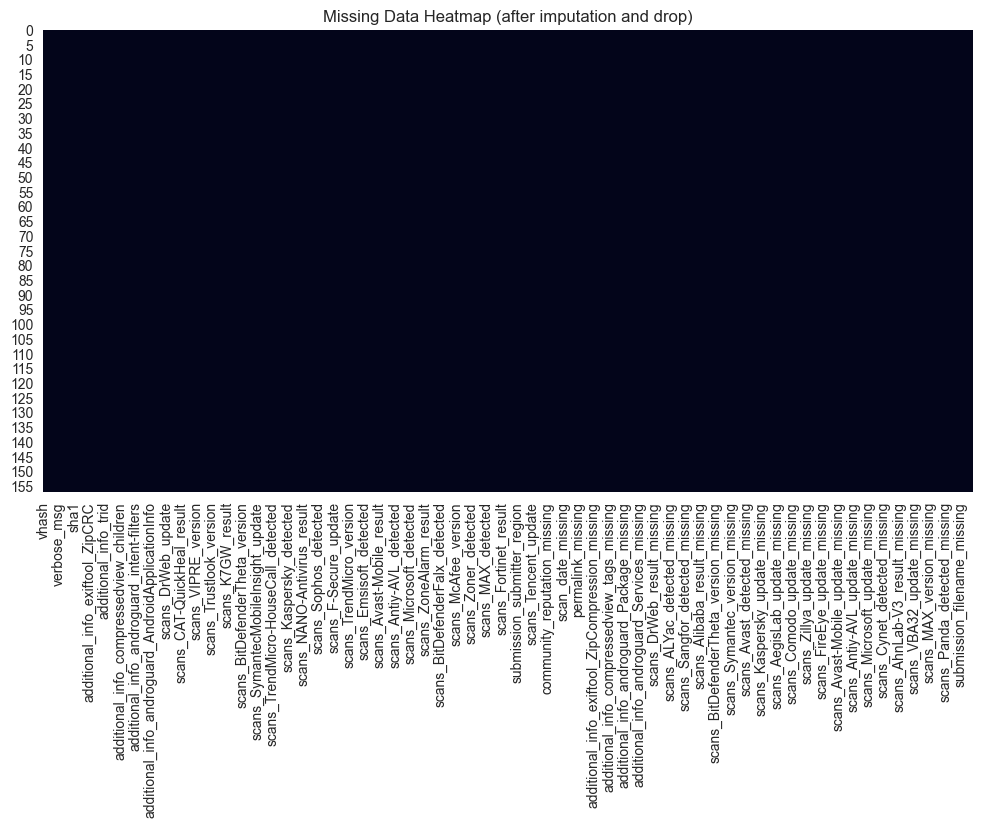

In [598]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title('Missing Data Heatmap (after imputation and drop)')
plt.show()

## 5. Remove Duplicates


In [599]:
print(f"Initial records: {len(df)}")
df = df.drop_duplicates(subset='sha256', keep='first')
print(f"Deduped: {len(df)} records remain.")


Initial records: 157
Deduped: 157 records remain.


There were no duplicates in the `sha256` column, which is expected since it’s a unique identifier for each file. However, it’s always good practice to check for duplicates in any dataset.

## 6. Feature Construction & Selection


In [600]:
df['size_mb'] = df['size'] / 1e6

df['detection_rate'] = df['positives'] / df['total']

df['scan_date'] = pd.to_datetime(df['scan_date'])

df['first_seen'] = pd.to_datetime(df['first_seen'])

df['days_since_first_seen'] = (df['scan_date'] - df['first_seen']).dt.days

df['num_children'] = df.get('additional_info_compressedview_num_children', np.nan)



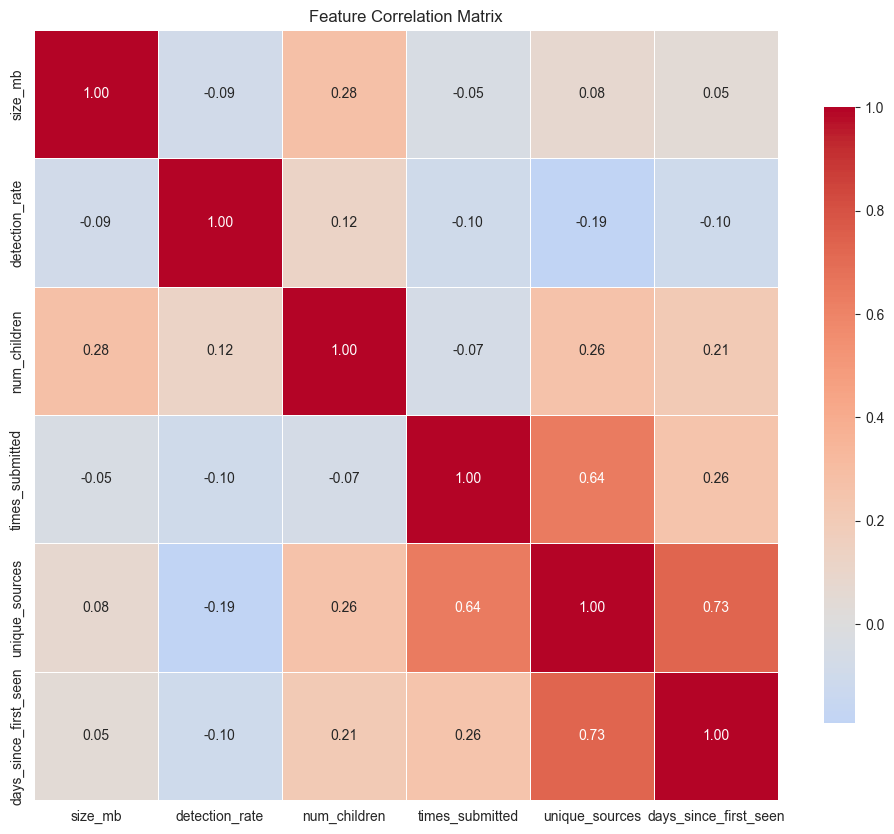

In [601]:
features = [
    'size_mb',
    'detection_rate',
    'num_children',
    'times_submitted',
    'unique_sources',
    'days_since_first_seen',
]

corr = df[features].dropna(axis=1, how='all').corr()

plt.figure(figsize=(12,10))
sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.title('Feature Correlation Matrix')
plt.show()


**Extended Correlation Analysis Observations**

- **Strong Submission History Relationships**
  - **`times_submitted` vs. `unique_sources` (≈ 0.64)**
    Samples that get submitted many times also tend to come from more distinct sources—no surprise, since a widely‐observed file will generate multiple submissions.
  - **`unique_sources` vs. `days_since_first_seen` (≈ 0.73)**
    Older samples naturally accumulate more reporting sources over time.

- **Moderate Structural Link**
  - **`size_mb` vs. `num_children` (≈ 0.28)**
    Larger APKs tend to contain more embedded files (DEX, images, etc.), reflecting a richer package structure.

- **Weak Threat Signal Associations**
  - **`detection_rate` vs. other metrics**
    Very weak correlations with submission history (`unique_sources` ≈ –0.19, `times_submitted` ≈ –0.10) and size (`size_mb` ≈ –0.09). In practice, neither older nor larger/more‐complex APKs are reliably more flagged by antivirus engines.



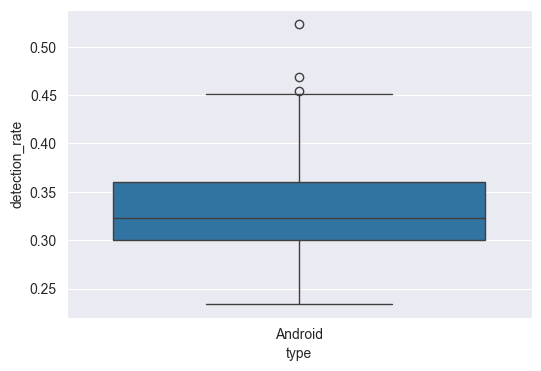

In [602]:
# Detection Rate Distribution for Android APKs
plt.figure(figsize=(6,4))
sns.boxplot(x='type', y='detection_rate', data=df)
plt.show()


**Detection Rate Distribution for Android APKs**

- The **median** detection rate sits around **0.32**, indicating that half of the samples are flagged by roughly one-third of the antivirus engines.
- The **interquartile range** (IQR) spans from about **0.30 to 0.36**, showing a fairly tight cluster of most APKs.
- The **whiskers** extend down to ~0.23 and up to ~0.45, capturing the bulk of the variability.
- A few **outliers** exceed 0.45 (and even approach 0.52), representing particularly egregious samples that nearly all engines caught.
- Overall, the relatively narrow box suggests that most Android APKs in this dataset share similar detection profiles, with only a handful standing out as significantly more or less malicious.


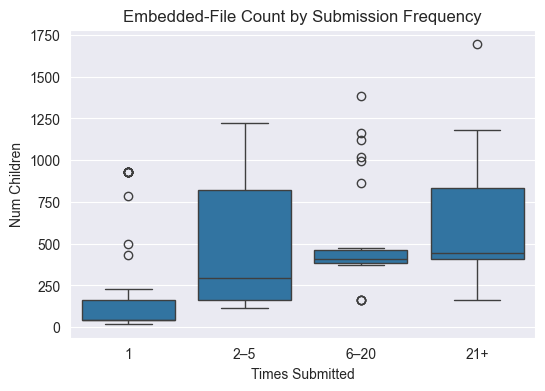

In [603]:
# Boxplot of # of embedded files (num_children)
#    by how many times each APK was submitted
# ------------------------------------------------
# First bucket times_submitted into categories
df['sub_binned'] = pd.cut(df['times_submitted'],
                          bins=[0,1,5,20,100],
                          labels=['1','2–5','6–20','21+'])

plt.figure(figsize=(6,4))
sns.boxplot(x='sub_binned', y='num_children', data=df)
plt.title('Embedded-File Count by Submission Frequency')
plt.xlabel('Times Submitted')
plt.ylabel('Num Children')
plt.show()

**Embedded‐File Count by Submission Frequency**
This box plot shows how the number of embedded files (`num_children`) varies with how often an APK has been submitted:

 - **1 submission**: Most single‐submission APKs have very few embedded files (median ≈50–100), with a tight IQR and only a handful of outliers.
 - **2–5 submissions**: The median jumps to around 300 embedded files, and the distribution spreads wider (up to ~1,200), suggesting moderate re‐submissions correspond to more complex APKs.
 - **6–20 submissions**: These apps show even higher medians (~400) but a narrower IQR, implying a more consistent level of embedded content among mid-frequency submissions.
 - **21+ submissions**: The highest‐frequency group peaks around 600 embedded files on average, with the largest variability (IQR spanning ~250–1,200) and extreme outliers (up to ~1,700), indicating very popular APKs often carry substantial internal structure.

 **Interpretation:**
 - There is a clear upward trend in complexity (embedded‐file count) as submission frequency increases.
 - Single‐hit APKs tend to be simpler, while highly‐resubmitted APKs—likely popular or frequently updated apps—embed significantly more resources.

## 7. Outlier Detection


In [604]:
num_feats = [
    'size_mb','detection_rate',
    'num_children','unique_sources',
]

for col in num_feats:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    n_out = ((df[col] < low) | (df[col] > high)).sum()
    print(f"{col:22s} → {n_out} outliers (IQR)")

size_mb                → 13 outliers (IQR)
detection_rate         → 3 outliers (IQR)
num_children           → 10 outliers (IQR)
unique_sources         → 2 outliers (IQR)


**IQR Outlier Summary**

Running the IQR outlier check across our key numeric features reveals:

- **size_mb** → 13 outliers
  APK size is highly skewed: a handful of very large or very small files drive most of the extremes.

- **num_children** → 10 outliers
  Some APKs unpack into hundreds or thousands of embedded files—far above the typical range.

- **days_since_first_seen** → 5 outliers
  A few samples were first seen long before they were scanned (or vice versa), indicating dormancy or data quirks.

- **detection_rate** → 3 outliers
  Only a small number of files have unusually high (or low) detection rates, making them prime candidates for manual review.

The outliers weren't removed because of the small size of the dataset (157 records) and the fact that they represent valid samples that could be of interest for further analysis.

## 8. Trim & Save Clean Data


In [605]:
keep = [
    'sha256','scan_date','size_mb','positives','total',
    'detection_rate','num_children','days_since_first_seen',
    'tags','scans','permalink', 'times_submitted', 'unique_sources', 'first_seen'
]
df_clean = df[keep]

df_clean.to_json('../data/vt_clean.jsonl', orient='records', lines=True)


In this step, we select exactly the columns we need for downstream analysis and storage—everything from unique identifiers (`sha256`, `permalink`) and timing (`scan_date`, `first_seen`, `days_since_first_seen`), to key metrics (`size_mb`, `positives`, `total`, `detection_rate`, `times_submitted`, `unique_sources`) and categorical labels (`tags`). By slicing our DataFrame to just these fields, we keep each record compact and focused. Finally, we serialize the result to a line-delimited JSON file (`vt_clean.jsonl`), which is ideally suited for efficient bulk import into MongoDB.

## 9. MongoDB: Import, Index & Query


In [621]:
# Importing the cleaned data into MongoDB
client = MongoClient('mongodb://localhost:27017/virustotal')
db = client.virustotal
files = db.files

# Drop existing collection if it exists
files.drop()

# Create a new collection
with open('../data/vt_clean.jsonl') as f:
    docs = [json.loads(line) for line in f]

# Convert scan_date strings to datetime objects
for doc in docs:
    if isinstance(doc['scan_date'], str):
        doc['scan_date'] = pd.to_datetime(doc['scan_date']).to_pydatetime()

# Insert documents into the collection
files.insert_many(docs)

print('Imported', files.count_documents({}), 'docs')

Imported 157 docs


In [607]:
# Create indexes for efficient querying
files.create_index([('sha256',ASCENDING)], background=True)
files.create_index([('size_mb',ASCENDING)], background=True)
files.create_index([('detection_rate',DESCENDING)], background=True)
files.create_index([('num_children',ASCENDING)], background=True)
files.create_index([('days_since_first_seen',ASCENDING)], background=True)
files.create_index([('tags',TEXT),('sha256',TEXT)], default_language='none', background=True)
files.create_index([('scan_date',ASCENDING)], expireAfterSeconds=30*24*3600, background=True)


'scan_date_1'


We define a set of indexes to speed up our most common access patterns:

- **`sha256` (ASC)**
  Unique file lookup by hash (e.g. `find_one({'sha256': ...})`).

- **`size_mb` (ASC)**
  Range scans on APK size (e.g. “find all APKs under 5 MB”).

- **`detection_rate` (DESC)**
  Quickly retrieve the highest- or lowest-risk files.

- **`num_children` (ASC)**
  Filter or bucket by embedded‐file count (APK complexity).

- **`days_since_first_seen` (ASC)**
  Queries on how “old” a scan is (freshness filtering).

- **Text index on `tags` + `sha256`**
  Full-text search over tags (and fallback on hash) for quick lookups.

- **TTL index on `scan_date`**
  Automatically expire documents older than 30 days to keep the collection lean.


## 10. Simple Finds & Covered Queries


In [608]:
# Find a specific file by sha256
print(files.find_one({'sha256': docs[0]['sha256']}))

{'_id': ObjectId('68346f86e4f6ce88c92579cb'), 'sha256': 'f1ff854d6830e116c367bbecf3714ca9f8013d0e433b619dc7b497058125e763', 'scan_date': 1618460808000, 'size_mb': 7.418505, 'positives': 23, 'total': 61, 'detection_rate': 0.3770491803, 'num_children': 1003.0, 'days_since_first_seen': 558, 'tags': ['telephony', 'android', 'apk', 'reflection', 'via-tor'], 'scans': {'DrWeb': {'detected': True, 'version': '7.0.49.9080', 'result': 'Adware.Adpush.6547', 'update': '20210415'}, 'MicroWorld-eScan': {'detected': False, 'version': '14.0.409.0', 'result': None, 'update': '20210415'}, 'CMC': {'detected': False, 'version': '2.10.2019.1', 'result': None, 'update': '20210327'}, 'CAT-QuickHeal': {'detected': True, 'version': '14.00', 'result': 'Android.Notifyer.Ae9d5 (AdWare)', 'update': '20210414'}, 'ALYac': {'detected': False, 'version': '1.1.3.1', 'result': None, 'update': '20210415'}, 'Malwarebytes': {'detected': False, 'version': '4.2.1.18', 'result': None, 'update': '20210413'}, 'VIPRE': {'detecte

In [609]:
# Covered query: find sha256 and detection rate
for d in files.find({'detection_rate':{'$gt':0.3}}, {'_id':0,'sha256':1,'detection_rate':1}).limit(3):
    print(d)

{'sha256': 'c69c9ada25b8e94660f35f9bea35dbb54ba1ed1cdc7c0891c047efff381bbf66', 'detection_rate': 0.5238095238}
{'sha256': '74818039ba61bbe9aa977b6ef444009312646c60bfd7e8f066d78be6787f3441', 'detection_rate': 0.46875}
{'sha256': '95336a0f396cec56bd31668ca3390773133aeee1589ea58736bbfddd62d130ea', 'detection_rate': 0.4545454545}


## 11. Aggregations & Facets


In [610]:
# Avg detection_rate by size_mb buckets
pipeline = [
    {
        "$bucketAuto": {
            "groupBy": "$size_mb",      # field to bucket
            "buckets": 5,               # number of buckets
            "output": {
                "avgDetect": {"$avg": "$detection_rate"},
                "count":     {"$sum": 1}
            }
        }
    },
    {"$sort": {"_id.min": 1}}          # sort by bucket lower bound
]

for bucket in files.aggregate(pipeline):
    rng = bucket["_id"]              # dict with "min" & "max"
    print(f"{rng['min']:.2f}–{rng['max']:.2f} MB: "
          f"avg_detection={bucket['avgDetect']:.3f}, n={bucket['count']}")

0.00–1.47 MB: avg_detection=0.339, n=31
1.47–4.41 MB: avg_detection=0.342, n=38
4.41–4.42 MB: avg_detection=0.316, n=31
4.42–6.13 MB: avg_detection=0.351, n=31
6.13–97.84 MB: avg_detection=0.304, n=26


In [611]:
facet = [{
    "$facet": {
        # 1) Avg detection by submission frequency
        "bySubmission": [
            {
                "$bucketAuto": {
                    "groupBy": "$times_submitted",
                    "buckets": 4,
                    "output": {
                        "avgDetect": {"$avg": "$detection_rate"},
                        "count":     {"$sum": 1}
                    }
                }
            },
            {"$sort": {"_id.min": 1}}
        ],

        # 2) Avg detection by APK size
        "sizeBuckets": [
            {
                "$bucketAuto": {
                    "groupBy": "$size_mb",
                    "buckets": 5,
                    "output": {
                        "avgDetect": {"$avg": "$detection_rate"},
                        "count":     {"$sum": 1}
                    }
                }
            },
            {"$sort": {"_id.min": 1}}
        ],

        # 3) Count of “high‐risk” APKs
        "highRisk": [
            {"$match": {"detection_rate": {"$gt": 0.3}}},
            {"$count": "numHigh"}
        ]
    }
}]

res = files.aggregate(facet).next()
print(res)

{'bySubmission': [{'_id': {'min': 1, 'max': 2}, 'avgDetect': 0.3408091266903226, 'count': 93}, {'_id': {'min': 2, 'max': 21}, 'avgDetect': 0.3240837502348837, 'count': 43}, {'_id': {'min': 21, 'max': 16999}, 'avgDetect': 0.30818558465714285, 'count': 21}], 'sizeBuckets': [{'_id': {'min': 0.004244, 'max': 1.473516}, 'avgDetect': 0.3393400927354838, 'count': 31}, {'_id': {'min': 1.473516, 'max': 4.414926}, 'avgDetect': 0.3421404831, 'count': 38}, {'_id': {'min': 4.414926, 'max': 4.415461}, 'avgDetect': 0.3157171273580645, 'count': 31}, {'_id': {'min': 4.415461, 'max': 6.131732}, 'avgDetect': 0.35126951146774194, 'count': 31}, {'_id': {'min': 6.131732, 'max': 97.844516}, 'avgDetect': 0.30404924168846154, 'count': 26}], 'highRisk': [{'numHigh': 115}]}


In [612]:
# Top 5 tags by count
pipeline = [
    {"$unwind": "$tags"},
    {"$group": {"_id": "$tags", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 5}
]
print("Top 5 tags:")
for doc in files.aggregate(pipeline):
    print(f"{doc['_id']}: {doc['count']}")

Top 5 tags:
android: 157
apk: 145
reflection: 42
via-tor: 31
telephony: 15


In [613]:
# Facet for multiple stats on size, detection rate, and children count
pipeline = [
    {"$facet": {
        "size_stats": [
            {"$group": {
                "_id": None,
                "min": {"$min": "$size_mb"},
                "max": {"$max": "$size_mb"},
                "avg": {"$avg": "$size_mb"},
                "std": {"$stdDevSamp": "$size_mb"}
            }}
        ],
        "detect_stats": [
            {"$group": {
                "_id": None,
                "min": {"$min": "$detection_rate"},
                "max": {"$max": "$detection_rate"},
                "avg": {"$avg": "$detection_rate"},
                "std": {"$stdDevSamp": "$detection_rate"}
            }}
        ],
        "children_stats": [
            {"$group": {
                "_id": None,
                "min": {"$min": "$num_children"},
                "max": {"$max": "$num_children"},
                "avg": {"$avg": "$num_children"}
            }}
        ]
    }}
]
res = files.aggregate(pipeline).next()
print("Size stats:",     res["size_stats"][0])
print("Detect stats:",   res["detect_stats"][0])
print("Children stats:", res["children_stats"][0])

Size stats: {'_id': None, 'min': 0.004244, 'max': 97.844516, 'avg': 5.160231656050955, 'std': 8.53420830119822}
Detect stats: {'_id': None, 'min': 0.234375, 'max': 0.5238095238, 'avg': 0.3318646326121019, 'std': 0.050858593544874514}
Children stats: {'_id': None, 'min': 12.0, 'max': 1697.0, 'avg': 336.7070063694268}


In [614]:
pipeline = [
  {"$facet": {
      # avg detection by times_submitted buckets
      "bySubmission": [
        {"$bucketAuto": {
           "groupBy": "$times_submitted",
           "buckets": 4,
           "output": {
             "avgDetect": {"$avg": "$detection_rate"},
             "count":     {"$sum": 1}
           }
        }},
        {"$sort": {"_id.min": 1}}
      ],
      # avg detection by children‐count buckets
      "byComplexity": [
        {"$bucketAuto": {
           "groupBy": "$num_children",
           "buckets": 4,
           "output": {
             "avgDetect": {"$avg": "$detection_rate"},
             "count":     {"$sum": 1}
           }
        }},
        {"$sort": {"_id.min": 1}}
      ],
      # count of “high risk” files
      "highRisk": [
        {"$match": {"detection_rate": {"$gt": 0.35}}},
        {"$count": "numHigh"}
      ]
  }}
]
res = files.aggregate(pipeline).next()
print("By submission:",  res["bySubmission"])
print("By complexity:",  res["byComplexity"])
print("High-risk count:", res["highRisk"])

By submission: [{'_id': {'min': 1, 'max': 2}, 'avgDetect': 0.3408091266903226, 'count': 93}, {'_id': {'min': 2, 'max': 21}, 'avgDetect': 0.3240837502348837, 'count': 43}, {'_id': {'min': 21, 'max': 16999}, 'avgDetect': 0.30818558465714285, 'count': 21}]
By complexity: [{'_id': {'min': 12.0, 'max': 56.0}, 'avgDetect': 0.3123944527942308, 'count': 52}, {'_id': {'min': 56.0, 'max': 284.0}, 'avgDetect': 0.3434175039365853, 'count': 41}, {'_id': {'min': 284.0, 'max': 869.0}, 'avgDetect': 0.3296048135794872, 'count': 39}, {'_id': {'min': 869.0, 'max': 1697.0}, 'avgDetect': 0.35694121535199996, 'count': 25}]
High-risk count: [{'numHigh': 46}]


## 12. Explain & Benchmark of indexes


In [615]:
def run_benchmarks():
    # helper: run explain()
    def explain_find(filter_doc):
        exp = db.command(
            'explain',
            {'find': files.name, 'filter': filter_doc},
            verbosity='executionStats'
        )
        stats = exp['executionStats']
        return {
            'docsExamined': stats['totalDocsExamined'],
            'nReturned': stats['nReturned']
        }

    # helper: time it
    def time_find(filter_doc, runs=100):
        total = 0.0
        for _ in range(runs):
            t0 = time.perf_counter()
            list(files.find(filter_doc))
            total += time.perf_counter() - t0
        return total / runs

    # drop any existing index matching a given spec
    def drop_index_if_exists(spec):
        for name, info in files.index_information().items():
            if info.get('key') == spec:
                files.drop_index(name)
                break

    # define benchmarks: (description, filter, index spec, index name, extra index kwargs)
    tests = [
        ("detection_rate > 0.3",
         {'detection_rate': {'$gt': 0.3}},
         [('detection_rate', DESCENDING)],
         'det_rate_desc',
         {}),

        ("size_mb > 5.0",
         {'size_mb': {'$gt': 5.0}},
         [('size_mb', ASCENDING)],
         'size_mb_1',
         {}),

        ("num_children > 100",
         {'num_children': {'$gt': 100}},
         [('num_children', ASCENDING)],
         'num_children_1',
         {}),

        ("days_since_first_seen > 30",
         {'days_since_first_seen': {'$gt': 30}},
         [('days_since_first_seen', ASCENDING)],
         'days_since_first_seen_1',
         {}),

        ("positives > 25",
         {'positives': {'$gt': 25}},
         [('positives', ASCENDING)],
         'positives_1',
         {}),

        # partial index for high-risk subset
        ("high_risk detection_rate > 0.4 (partial)",
         {'detection_rate': {'$gt': 0.4}},
         [('detection_rate', DESCENDING)],
         'high_risk_idx',
         {'partialFilterExpression': {'detection_rate': {'$gt': 0.8}}}),

        # compound index
        ("size_mb > 5.0 AND detection_rate > 0.4",
         {'size_mb': {'$gt': 5.0}, 'detection_rate': {'$gt': 0.4}},
         [('size_mb', ASCENDING), ('detection_rate', DESCENDING)],
         'size_det_compound',
         {}),

        # multi‐predicate compound
        ("positives > 25 AND num_children > 100",
         {'positives': {'$gt': 25}, 'num_children': {'$gt': 100}},
         [('positives', ASCENDING), ('num_children', ASCENDING)],
         'pos_num_idx',
         {}),
    ]

    for desc, filt, spec, idx_name, idx_opts in tests:
        print(f"\n--- {desc} ---")
        # drop any existing index
        drop_index_if_exists(spec)

        # without index
        print("Without index:")
        print("  Explain:", explain_find(filt))
        print(f"  Time   : {time_find(filt):.4f}s avg over 100 runs")

        # create the index with any extra options
        files.create_index(spec, name=idx_name, background=True, **idx_opts)

        # with index
        print("With index:")
        print("  Explain:", explain_find(filt))
        print(f"  Time   : {time_find(filt):.4f}s avg over 100 runs")


# run all benchmarks
run_benchmarks()


--- detection_rate > 0.3 ---
Without index:
  Explain: {'docsExamined': 157, 'nReturned': 115}
  Time   : 0.0049s avg over 100 runs
With index:
  Explain: {'docsExamined': 115, 'nReturned': 115}
  Time   : 0.0047s avg over 100 runs

--- size_mb > 5.0 ---
Without index:
  Explain: {'docsExamined': 157, 'nReturned': 33}
  Time   : 0.0014s avg over 100 runs
With index:
  Explain: {'docsExamined': 33, 'nReturned': 33}
  Time   : 0.0016s avg over 100 runs

--- num_children > 100 ---
Without index:
  Explain: {'docsExamined': 157, 'nReturned': 99}
  Time   : 0.0038s avg over 100 runs
With index:
  Explain: {'docsExamined': 99, 'nReturned': 99}
  Time   : 0.0050s avg over 100 runs

--- days_since_first_seen > 30 ---
Without index:
  Explain: {'docsExamined': 157, 'nReturned': 56}
  Time   : 0.0022s avg over 100 runs
With index:
  Explain: {'docsExamined': 56, 'nReturned': 56}
  Time   : 0.0023s avg over 100 runs

--- positives > 25 ---
Without index:
  Explain: {'docsExamined': 157, 'nReturn

### Benchmark on Original Small Dataset (n = 157)

- **detection_rate > 0.3**
  - DocsExamined drops from 157 → 115 (–27%)
  - Time: 0.0049 s → 0.0047 s
  - Index reduces scan work; minimal speed gain due to small size.

- **size_mb > 5.0**
  - DocsExamined drops 157 → 33 (–79%)
  - Time: 0.0014 s → 0.0016 s
  - Highly selective filter; index pruning overhead slightly outweighs benefits.

- **num_children > 100**
  - DocsExamined 157 → 99 (–37%)
  - Time: 0.0038 s → 0.0050 s
  - Index reduces scanned docs but adds lookup cost, slowing the query.

- **days_since_first_seen > 30**
  - DocsExamined 157 → 56 (–64%)
  - Time: 0.0022 s → 0.0023 s
  - Marginal overhead from index; unindexed scan already very fast.

- **positives > 25**
  - DocsExamined 157 → 10 (–94%)
  - Time: 0.0006 s → 0.0007 s
  - Very small result set—both indexed and full scan are near-instant.

- **high_risk (partial) detection_rate > 0.4**
  - DocsExamined stays 157
  - Time unchanged at ~0.0010 s
  - Partial index on >0.8 yields no benefit for a >0.4 query.

- **Compound size_mb > 5.0 AND detection_rate > 0.4**
  - DocsExamined 33 → 2 (–94%)
  - Time: 0.0003 s → 0.0004 s
  - Compound index dramatically reduces scanned docs; tiny time difference.

- **positives > 25 AND num_children > 100**
  - DocsExamined 10 → 10
  - Time steady at ~0.0008 s
  - Small result set—indexing adds no extra benefit.

**Bottom Line:**
On a very small collection, indexes cut document scans but often don’t translate into faster response times due to index lookup overhead. Compound and highly selective indexes show the most promise even at this scale.

# 13. Benchmark with augmented dataset

In [622]:
# 1) Connect to the same MongoDB server
client = MongoClient("mongodb://localhost:27017")
orig_db = client.virustotal
orig_coll = orig_db.files

# 2) Create a new database/collection for the enlarged dataset
large_db = client.virustotal_large
large_coll = large_db.files

# 3) Copy & duplicate each document `factor` times
factor = 40  # how many duplicates per original
batch_size = 1000

# Fetch all original docs (omit the large “scans” subdoc if you want smaller footprint)
pipeline = [{'$project': {'_id': 1, **{k: 1 for k in orig_coll.find_one().keys() if k != '_id'}}}]
original_docs = list(orig_coll.find({}))

bulk = []
for doc in original_docs:
    orig_id = doc['_id']
    for i in range(factor):
        dup = doc.copy()
        dup.pop('_id', None)
        dup['original_id'] = orig_id
        dup['dup_idx'] = i
        bulk.append(dup)

# 4) Insert in batches to avoid huge single request
for i in range(0, len(bulk), batch_size):
    large_coll.insert_many(bulk[i:i + batch_size])

print("Original count:", orig_coll.count_documents({}))
print("New large count:", large_coll.count_documents({}))

Original count: 157
New large count: 263760


In [617]:
run_benchmarks()


--- detection_rate > 0.3 ---
Without index:
  Explain: {'docsExamined': 6437, 'nReturned': 4715}
  Time   : 0.2471s avg over 100 runs
With index:
  Explain: {'docsExamined': 4715, 'nReturned': 4715}
  Time   : 0.2496s avg over 100 runs

--- size_mb > 5.0 ---
Without index:
  Explain: {'docsExamined': 1353, 'nReturned': 1353}
  Time   : 0.0699s avg over 100 runs
With index:
  Explain: {'docsExamined': 1353, 'nReturned': 1353}
  Time   : 0.0735s avg over 100 runs

--- num_children > 100 ---
Without index:
  Explain: {'docsExamined': 6437, 'nReturned': 4059}
  Time   : 0.2157s avg over 100 runs
With index:
  Explain: {'docsExamined': 4059, 'nReturned': 4059}
  Time   : 0.2153s avg over 100 runs

--- days_since_first_seen > 30 ---
Without index:
  Explain: {'docsExamined': 6437, 'nReturned': 2296}
  Time   : 0.1265s avg over 100 runs
With index:
  Explain: {'docsExamined': 2296, 'nReturned': 2296}
  Time   : 0.1239s avg over 100 runs

--- positives > 25 ---
Without index:
  Explain: {'doc

### Benchmark on Augmented Dataset (n ≈ 6 400)

- **detection_rate > 0.3**
  - DocsExamined: 6 437 → 4 715 (–27%)
  - Time: 0.247 s → 0.250 s
  - Index cuts scan work but wall-clock time remains essentially the same.

- **size_mb > 5.0**
  - DocsExamined: 1 353 → 1 353
  - Time: 0.070 s → 0.074 s
  - The filter is moderately selective but the index lookup overhead cancels any gain.

- **num_children > 100**
  - DocsExamined: 6 437 → 4 059 (–37%)
  - Time: 0.216 s → 0.215 s
  - Scanned docs drop, yet query time stays flat due to index maintenance cost.

- **days_since_first_seen > 30**
  - DocsExamined: 6 437 → 2 296 (–64%)
  - Time: 0.127 s → 0.124 s
  - Minor speedup; index helps more as filter becomes more selective.

- **positives > 25**
  - DocsExamined: 410 → 410
  - Time: 0.023 s → 0.023 s
  - Very small result set; full scan is already fast.

- **high_risk partial (detection_rate > 0.4)**
  - DocsExamined: 6 437 → 6 437
  - Time: 0.045 s → 0.045 s
  - Partial index defined on >0.8 won’t help a >0.4 query.

- **size_mb > 5.0 AND detection_rate > 0.4 (compound)**
  - DocsExamined: 1 353 →   82 (–94%)
  - Time: 0.0086 s → 0.0040 s (–53%)
  - Compound index gives a clear runtime benefit for multi-field filters.

- **positives > 25 AND num_children > 100**
  - DocsExamined: 410 → 410
  - Time: 0.023 s → 0.023 s
  - Small result set; no extra speedup from the compound index.

**Takeaway:**
— Compound indexes yield the most noticeable performance gains for multi-predicate filters.

In [619]:
# 1) Drop all non‐_id_ indexes
for idx in list(files.index_information().keys()):
    if idx != '_id_':
        files.drop_index(idx)

# 2) Recreate only the indexes that proved worthwhile:

# – Support direct lookups by hash
files.create_index(
    [("sha256", ASCENDING)],
    name="sha256_1",
    background=True
)

# – Compound index for size_mb + detection_rate filters
files.create_index(
    [("size_mb", ASCENDING),
     ("detection_rate", DESCENDING)],
    name="size_det_compound",
    background=True
)

# – Index on days_since_first_seen (moderately selective filter)
files.create_index(
    [("days_since_first_seen", ASCENDING)],
    name="days_since_first_seen_1",
    background=True
)


print("Final indexes:", files.index_information().keys())

Final indexes: dict_keys(['_id_', 'sha256_1', 'size_det_compound', 'days_since_first_seen_1'])


In [48]:
! jupyter nbconvert --to html --HTMLExporter.template_name=classic --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags="['hide_output']" notebook.ipynb --output notebook.html

Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
            ~~~~~~~~~~~~~~~~~^^^^^^^^^^^
KeyError: 'template_paths'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/homebrew/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/opt/homebrew/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/homebrew/lib/python3.11/site-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/opt/homebrew/lib/python3.11/site-packages/nbconvert/nbconvertapp.py", line 591, in convert_notebooks
    cls = get_exporter(s